In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from keras.optimizers import Adam

from matplotlib import pyplot as plt
from wasserstein_loss import wasserstein_generator_loss, wasserstein_discriminator_loss
from tabular_wgan_gp import tabularWGANGP
from tabular_discriminator import build_discriminator
from tabular_generator import build_generator

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Building the model

In [3]:
latent_dim = 32
out_shape = 30
num_classes = 1

In [4]:
generator = build_generator(latent_dim = latent_dim, num_classes = num_classes, out_shape = out_shape, layers_dim=[128,256])

In [5]:
discriminator = build_discriminator(out_shape = out_shape, num_classes = num_classes, layers_dim=[256,128])

In [6]:
model = tabularWGANGP(generator, discriminator, latent_dim = latent_dim, out_shape = out_shape,
                     num_classes = num_classes, d_steps=10)
model.compile(    
    discriminator_optimizer=Adam(learning_rate=2e-4,beta_1=0.5,beta_2=0.9),
    generator_optimizer=Adam(learning_rate=2e-4,beta_1=0.5,beta_2=0.9),
    discriminator_loss = wasserstein_discriminator_loss,
    generator_loss = wasserstein_generator_loss
)

## Reading and preprocessing the data

In [7]:
df = pd.read_csv('data/original/creditcard.csv')
df.shape

(284807, 31)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

y = df["Class"].values
x = df.drop(["Class"],1)

scaler = preprocessing.StandardScaler()

x = scaler.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4)

df_fraud = df[df["Class"] == 1]

yf = df_fraud["Class"].values
xf = df_fraud.drop(["Class"],1)

xf = scaler.fit_transform(xf)

xf_train, yf_train = xf, yf

In [9]:
# setting up constants
epochs = 100
batch_size = 32

In [10]:
dataset = tf.data.Dataset.from_tensor_slices((xf_train,yf_train))
dataset = dataset.shuffle(buffer_size=128).batch(batch_size)

In [11]:
model.fit(dataset, epochs = epochs, batch_size=batch_size)

Epoch 1/50
16/16 [==============================] - 15s 113ms/step - g_loss: 0.1323 - d_loss: 1.5773
Epoch 2/50
16/16 [==============================] - 3s 163ms/step - g_loss: -0.6240 - d_loss: -2.4366
Epoch 3/50
16/16 [==============================] - 3s 165ms/step - g_loss: -1.0074 - d_loss: -2.1357
Epoch 4/50
16/16 [==============================] - 1s 90ms/step - g_loss: -0.3989 - d_loss: -1.9262
Epoch 5/50
16/16 [==============================] - 1s 70ms/step - g_loss: -0.5121 - d_loss: -1.6548
Epoch 6/50
16/16 [==============================] - 1s 75ms/step - g_loss: -0.6951 - d_loss: -1.7387
Epoch 7/50
16/16 [==============================] - 1s 68ms/step - g_loss: 0.6062 - d_loss: -1.6937
Epoch 8/50
16/16 [==============================] - 1s 50ms/step - g_loss: 0.4357 - d_loss: -1.8807
Epoch 9/50
16/16 [==============================] - 1s 48ms/step - g_loss: 0.6466 - d_loss: -1.6688
Epoch 10/50
16/16 [==============================] - 1s 51ms/step - g_loss: 0.9552 - d_loss:

## Classification on original train dataset

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    113731
           1       0.93      0.73      0.82       192

    accuracy                           1.00    113923
   macro avg       0.96      0.86      0.91    113923
weighted avg       1.00      1.00      1.00    113923



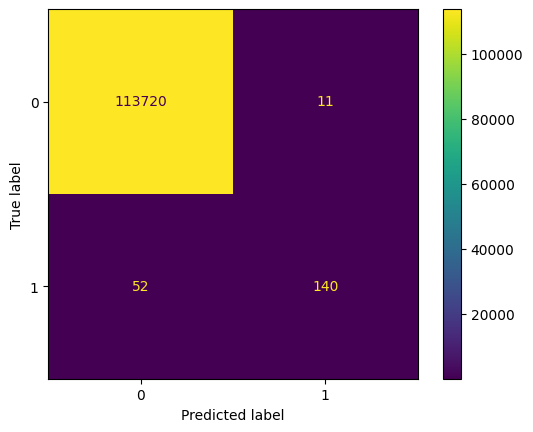

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            plot_confusion_matrix, confusion_matrix

# first train a random forest classifier on the original data
rf = RandomForestClassifier(n_estimators = 10, random_state = 42)
rf.fit(x_train,y_train)

y_pred = rf.predict(x_test)

# evaluation
print(classification_report(y_test, y_pred))
plot_confusion_matrix(rf, x_test, y_test)
plt.show()

## Generating synthetic minority class data samples

In [13]:
df["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [16]:
# generate data using trained model
noise = np.random.normal(0, 1, (283800, latent_dim))
sampled_labels = np.ones(283800).reshape(-1, 1)

gen_samples = model.generator.predict([noise, sampled_labels])

gen_samples_scaled = scaler.inverse_transform(gen_samples)

gen_df = pd.DataFrame(data = gen_samples_scaled,
                      columns = df.drop('Class',1).columns)

gen_df['Class'] = 1

df_balanced = pd.concat([df, gen_df], ignore_index=True, sort=False)
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

x_train_2 = scaler.fit_transform(df_balanced.drop('Class', 1))
y_train_2 = df_balanced['Class'].values

8869/8869 [==============================] - 10s 1ms/step


In [17]:
df_balanced.shape

(568607, 31)

              precision    recall  f1-score   support

           0       1.00      0.88      0.93    113731
           1       0.01      0.87      0.02       192

    accuracy                           0.88    113923
   macro avg       0.51      0.87      0.48    113923
weighted avg       1.00      0.88      0.93    113923



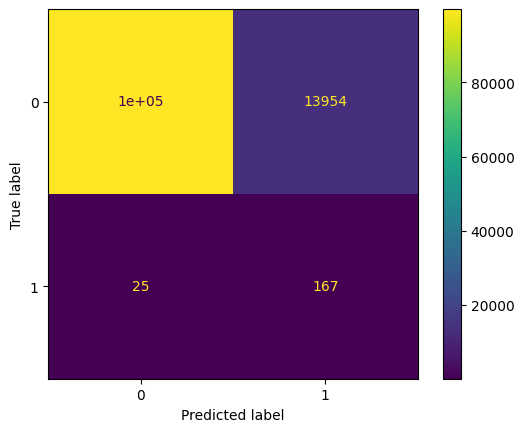

In [18]:
# now train a different instance of random forest classifier with the same parameters on generated data
rf1 = RandomForestClassifier(n_estimators = 10, random_state = 42)
rf1.fit(x_train_2,y_train_2)

y_pred = rf1.predict(x_test)

# evaluation
print(classification_report(y_test, y_pred))
plot_confusion_matrix(rf1, x_test, y_test)
plt.show()